In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station= Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set in measurment table. 
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent)

('2017-08-23',)


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Part 1: Starting from the most recent data point in the database. 
print(dt.date(2017, 8 ,23))

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(year_ago)


2017-08-23
2016-08-23


In [12]:
# Part 2: Perform a query to retrieve the data and precipitation scores
station_results = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()
station_results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Part 3: Perform a query to retrieve the data and precipitation scores
prcp_score = session.query(measurement.date, measurement.prcp).\
                    filter(measurement.date >= '2016-08-23').\
                    filter(measurement.date <= '2017-08-23').all()
                                  
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_score_df = pd.DataFrame(prcp_score, columns=['date', 'prcp'])
prcp_score_df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_prcp = prcp_score_df.sort_index()
sorted_prcp.head()

prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15

<Figure size 1440x576 with 0 Axes>

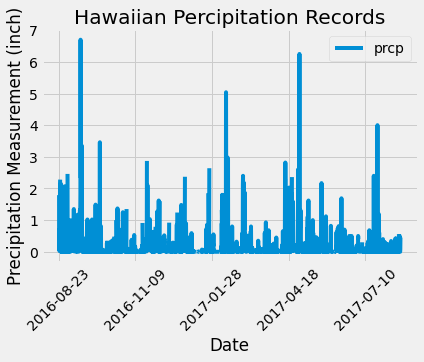

In [14]:
# Part 4: Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(20,8))
sorted_prcp.plot()
plt.xticks(rotation=45)
plt.title("Hawaiian Percipitation Records")
plt.xlabel("Date")
plt.ylabel("Precipitation Measurement (inch)")  
plt.savefig("Hawaiian Percipitation Records.png")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_mean = sorted_prcp["prcp"].mean().round(3)
prcp_median = sorted_prcp["prcp"].median().round(3)
prcp_var = sorted_prcp["prcp"].var().round(3)
prcp_stdev = sorted_prcp["prcp"].std().round(3)
prcp_min = sorted_prcp["prcp"].min()
prcp_max = sorted_prcp["prcp"].max()

print(f'Precipitation statistics for Hawaii mean {prcp_mean}", median {prcp_median}", variance {prcp_var}",\
 standard deviation {prcp_stdev}", minimum {prcp_min}", and maximum {prcp_max}"')

Precipitation statistics for Hawaii mean 0.177", median 0.02", variance 0.213", standard deviation 0.461", minimum 0.0", and maximum 6.7"


In [16]:
####ALTERNATIVE CODE FOR STATISTICAL ANALYSIS######
sorted_prcp.describe()

prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station).count()
print(station_count)

####ALTERNATIVE CODE FOR UNIQUE STATION###### 
unique_number = session.query(measurement).group_by(measurement.station).count()
print(unique_number)

9
9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
unique_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

unique_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
#Calculate the lowest, highest, and average temperature for most frequently reporting station USC00519281.
#Using the func.min, func.max, func.avg, and func.count in queries.
temp_results = session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
filter(measurement.station == "USC00519281").all()
temp_results


[(54.0, 71.66378066378067, 85.0)]

In [20]:
#####ALTERNATIVE METHOD FOR STATISTICAL METHOD######
temperature = [measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs]

station_temp = session.query(*temperature)
station_temp_df = pd.DataFrame(station_temp, columns=['id', 'station', 'date', 'prcp', 'temp'])
station_temp_df.set_index('id', inplace=True)

waihee_station = station_temp_df.loc[station_temp_df["station"]=="USC00519281"]

temp_min = waihee_station["temp"].min()
temp_max = waihee_station["temp"].max()
temp_avg = waihee_station["temp"].mean().round(1)
print(f'Waihee station minimum temp is {temp_min}F, the maximum temp is {temp_max}, and the average temp is {temp_avg}F')


Waihee station minimum temp is 54.0F, the maximum temp is 85.0, and the average temp is 71.7F


In [21]:
# Using the most active station id "station USC00519281"
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
annualized = session.query(measurement.id, measurement.station, measurement.date, measurement.tobs).\
filter(measurement.date > '2016-08-23').\
filter(measurement.date < '2017-08-23').\
filter(measurement.station == "USC00519281").all()

#Create a dataframe from filtered query
waihee_annual = pd.DataFrame(annualized, columns=['id','station', 'date', 'temp'])
waihee_annual.set_index('id', inplace=True)
waihee_annual.head()

station        date  temp
id                                  
14609  USC00519281  2016-08-24  77.0
14610  USC00519281  2016-08-25  80.0
14611  USC00519281  2016-08-26  80.0
14612  USC00519281  2016-08-27  75.0
14613  USC00519281  2016-08-28  73.0

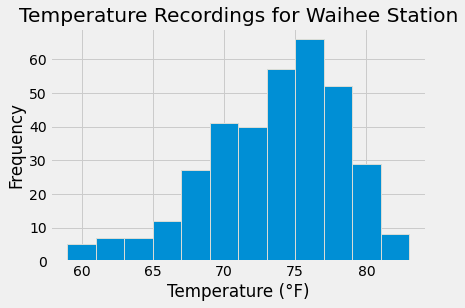

In [22]:
#plot the data in a historgram
temperature = waihee_annual["temp"]
plt.hist(temperature, bins=12, edgecolor='xkcd:light gray', linewidth=1,)
plt.title("Temperature Recordings for Waihee Station")
plt.xlabel('Temperature (°F)')
plt.ylabel("Frequency")
plt.savefig("Waihee Station Histogram.png")
plt.show()

# Close session

In [23]:
# Close Session
session.close()